# SIR MODEL - NDL
**Network Diffusion Library** https://ndlib.readthedocs.io/en/latest/reference/reference.html

In the code below is shown an example of instantiation and execution of an SIR simulation on a random graph: we set the initial set of infected nodes as 5% of the overall population, a probability of infection of 1%, and a removal probability of 0.5%.


In [217]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep

from utils.sdrf import sdrf
from utils import fosr
import utils.data_loader as loader

import numpy as np
import torch
import matplotlib.pyplot as plt

import copy
import os
import pickle
%matplotlib inline

In [218]:
def get_cosine(GW):
    from sklearn.metrics.pairwise import cosine_similarity
    from scipy.sparse import coo_matrix

    edge_index = GW.edgelist.detach().cpu()
    n = GW.num_nodes
    adj_sparse = coo_matrix((np.ones(edge_index.shape[1]), (edge_index[0], edge_index[1])),
                        shape=(n, n))

    # Compute cosine similarity using sklearn
    cos_sim = cosine_similarity(adj_sparse)

    return torch.Tensor(cos_sim)

def get_strongest_link2(score, edge_mask, n = None):
    score[torch.logical_not(edge_mask)]=torch.inf
    min = score.min().item()
    argmins = (score == min).nonzero()
    rand_argmin = np.random.choice(argmins.squeeze().shape[0])
    u = argmins[rand_argmin][0]
    v = argmins[rand_argmin][1]
    return u,v
    #n = score.shape[0] if n is None else n
    #u, v = divmod(argmin, n)
    return argmins#, u, v

def get_weakest_link2(score, edge_mask, n = None):
    argmax = (score*edge_mask).argmax().item() #detach and cpu on call
    n = score.shape[0] if n is None else n
    u, v = divmod(argmax, n)
    return u, v

#from standard deviation to 95% CI
import scipy.stats as st
def CI(std, runs, confidence=0.95):
    return 1.96 * (std/np.sqrt(runs))

In [219]:
from utils.GraphWrapper import GraphWrapper
import utils.link_addition_torch as lkadd
from tqdm import tqdm
def add_links(GW, N_LINKS, MODEL):
    if not MODEL in ['fosr', 'sdrf']:
        for i in tqdm(range(N_LINKS)):
            #* Get score
            if MODEL == 'random':
                u, v = lkadd.get_random_link(GW.edge_mask)
            elif MODEL == 'ERP':
                S = GW.get_effective_resistance()

            elif MODEL == 'cosine':
                S = get_cosine(GW)
            else:
                opt_args = {'dim': 128, 'walk_length': 40, 'window_size': 10, 'workers': 4} if MODEL == 'deepwalk' else  {}
                S = lkadd.get_edge_score(GW, MODEL, **opt_args)

            #* Select edge based on score
            if MODEL != 'random':
                if MODEL == 'ERP':
                    u,v = lkadd.get_weakest_link(S.cpu().detach(), GW.edge_mask.cpu().detach(), GW.num_nodes)
                elif MODEL == 'cosine':
                    u,v = get_strongest_link2(S.cpu().detach(), GW.edge_mask.cpu().detach(), GW.num_nodes)
                else:
                    u,v = lkadd.get_strongest_link(S.cpu().detach(), GW.edge_mask.cpu().detach(), GW.num_nodes)
            #print(S.min().item(), S.max().item(), S[u,v].item())
            
            if GW.is_edge(u,v):
                raise Exception('Edge already exists')
            else:
                GW.add_link(u,v)
    else:
        if MODEL == 'sdrf':
            GW, added_links_sdrf = sdrf(copy.deepcopy(GW), loops=N_LINKS, remove_edges=False, removal_bound=2, is_undirected=True, tau=0.9)
            #G_sdrf = G.copy()
            #for e in added_links_sdrf:
            #    G_sdrf.add_edge(e[0],e[1])
        elif MODEL == 'fosr':
            new_edgelist_fosr = fosr.edge_rewire(copy.deepcopy(GW).edgelist.numpy(), num_iterations=N_LINKS, initial_power_iters=10)[0]
            # added_links_fosr to list
            #added_links_fosr = new_edgelist_fosr[:,-N_LINKS*2:].T.tolist()
            #G_fosr = G.copy()
            #for e in added_links_fosr:
            #    G_fosr.add_edge(e[0],e[1])
            GW = GraphWrapper(edgelist=torch.LongTensor(new_edgelist_fosr))
        else:
            raise Exception('Model not supported')

    return GW

**IC MODEL**

In [220]:
#! SIR and IC models

def SIR(G, beta=0.005, lambda_sir=0.00, fraction_infected=0.001, iterations=100):
    """SIR model: susceptible-infected-recovered model

    Args:
        G (_type_): _description_
        beta (float, optional): beta is the infection rate. Defaults to 0.005.
        lambda_sir (float, optional): lambda represents the recovery rate.
        fraction_infected (float, optional): fraction_infected is the fraction of infected nodes at the beginning of the simulation. Defaults to 0.001.
        iterations (int, optional): iterations is the number of iterations the simulation will run. Defaults to 100.

    Returns:
        _type_: _description_
    """

    # Model selection
    #model = ep.SIRModel(G)
    model = ep.SISModel(G)

    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)
    #cfg.add_model_parameter('gamma', 0.00)
    cfg.add_model_parameter('lambda', lambda_sir)
    cfg.add_model_parameter("fraction_infected", fraction_infected)
    model.set_initial_status(cfg)

    # Simulation execution
    history = model.iteration_bunch(iterations)
    return history


def IC_model(G, initial_infected=0.1, threshold=0.2, iterations_IC=100, initial_inf_nodes = None):
    # Model selection
    model = ep.IndependentCascadesModel(G)

    # Model Configuration
    config = mc.Configuration()
    if initial_inf_nodes is None:
        raise Exception('initial_inf_nodes must be specified')
    #config.add_model_parameter('fraction_infected', initial_infected)
    else:
        config.add_model_initial_configuration('Infected', initial_inf_nodes)

    # Setting the edge parameters
    for e in G.edges():
        config.add_edge_configuration("threshold", e, threshold)

    model.set_initial_status(config)

    # Simulation execution
    iterations = model.iteration_bunch(iterations_IC)

    return model, iterations

**RUN IC model**

In [221]:
DATASET = 'facebook' #'facebook'
DEVICE = 'cuda'
N_LINKS = 100

GW = loader.load_data(DATASET, device=DEVICE)
GW.num_edges, GW.num_nodes

Loaded Graph with 1034 nodes and 26749 edges - L computation mode: exact


(26749, 1034)

In [222]:
def get_groups(data): 
    if data == 'google':
        rename_groups = {
            1:'Male',
            0:'Female',
        }
        male=1
        female=0
    else:
        rename_groups = {
            1:'Female',
            0:'Male'
        }
        male=0
        female=1
    return rename_groups, male, female
_, male, female = get_groups(DATASET)
unique_values, counts = torch.unique(GW.sens, return_counts=True)
attribute_counts = dict(zip(unique_values.tolist(), counts.tolist()))
attribute_counts

{0.0: 685, 1.0: 349}

Load data

In [223]:
def load_augmented_graph_IC(dataset_name, num_added_links):
    GW = loader.load_data(DATASET, device=DEVICE)
    if os.path.exists(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_ERP.pkl'):
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_ERP.pkl', 'rb') as f:
            GW_erp = pickle.load(f)
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_COS.pkl', 'rb') as f:
            GW_cos = pickle.load(f)
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_RAND.pkl', 'rb') as f:
            GW_rand = pickle.load(f)
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_FOSR.pkl', 'rb') as f:
            GW_fosr = pickle.load(f)
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_SDRF.pkl', 'rb') as f:
            GW_sdrf = pickle.load(f)
    else:
        GW_cos = add_links(copy.copy(GW), num_added_links, 'cosine')
        GW_rand = add_links(copy.copy(GW), num_added_links, 'random')
        GW_erp = add_links(copy.copy(GW), num_added_links, 'ERP')
        GW_fosr = add_links(copy.copy(GW), num_added_links, 'fosr')
        GW_sdrf = add_links(copy.copy(GW), num_added_links, 'sdrf')


        if not os.path.exists('temp_data'):
            os.makedirs('temp_data')

        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_ERP.pkl', 'wb') as f:
            pickle.dump(GW_erp, f)
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_COS.pkl', 'wb') as f:
            pickle.dump(GW_cos, f)
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_RAND.pkl', 'wb') as f:
            pickle.dump(GW_rand, f)  
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_FOSR.pkl', 'wb') as f:
            pickle.dump(GW_fosr, f)
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_SDRF.pkl', 'wb') as f:
            pickle.dump(GW_sdrf, f)

    return {'G':GW, 'ERP': GW_erp, 'COS': GW_cos, 'RAND': GW_rand, 'FOSR': GW_fosr, 'SDRF': GW_sdrf}

In [224]:
wrappers = load_augmented_graph_IC(DATASET, N_LINKS)

Loaded Graph with 1034 nodes and 26749 edges - L computation mode: exact


In [225]:
GW = wrappers['G']
GW_erp = wrappers['ERP']
GW_cos = wrappers['COS']
GW_rand = wrappers['RAND']
GW_fosr = wrappers['FOSR']
GW_sdrf = wrappers['SDRF']

for gg in wrappers:
    if wrappers[gg].sens is None:
        wrappers[gg].sens = torch.Tensor(GW.sens)

In [226]:
R_ori = GW.get_effective_resistance()
R_cos = GW_cos.get_effective_resistance()
R_erp = GW_erp.get_effective_resistance()
R_fosr = GW_fosr.get_effective_resistance()
R_sdfr = GW_sdrf.get_effective_resistance()
R_rand = GW_rand.get_effective_resistance()

print(f"""Total effective resistance
    Original:\t {R_ori.sum().item():.1f}
    Cosine:\t {R_cos.sum().item():.1f}
    ERP:\t {R_erp.sum().item():.1f}
    FOSR:\t {R_fosr.sum().item():.1f}
    SDRF:\t {R_sdfr.sum().item():.1f}
    Random:\t {R_rand.sum().item():.1f}""")


Total effective resistance
    Original:	 200451.9
    Cosine:	 182360.1
    ERP:	 114504.7
    FOSR:	 168345.0
    SDRF:	 199304.6
    Random:	 169257.2


In [227]:
def to_nx(GWr, node_attribute):
    gg = nx.Graph()
    gg.add_edges_from(GWr.edgelist.T.numpy())
    nx.set_node_attributes(gg, {i:node_attribute[i] for i in range(GWr.num_nodes)}, 'sens')
    return gg

In [228]:
#from edgelist to networkx
wrappers_nx = dict()

G = to_nx(GW, GW.sens)
G_erp = to_nx(GW_erp, GW_erp.sens)
G_cos = to_nx(GW_cos, GW_cos.sens)
G_rand = to_nx(GW_rand, GW_rand.sens)
G_fosr = to_nx(GW_fosr, GW.sens)
G_sdrf = to_nx(GW_sdrf, GW_sdrf.sens)

wrappers_nx = {'G':G, 'ERP': G_erp, 'COS': G_cos, 'RAND': G_rand, 'FOSR': G_fosr, 'SDRF': G_sdrf}

G.number_of_edges(), G_erp.number_of_edges(), G_cos.number_of_edges(), G_rand.number_of_edges(), G_fosr.number_of_edges()

(26749, 26849, 26849, 26849, 26849)

## Get seed nodes

In [586]:
#get node of min degree from G
min_degree_node, min_degree = min(G.degree, key=lambda x: x[1])
top_min_degree_nodes = [xx[0] for xx in sorted(G.degree, key=lambda x: x[1])[:5]]
nodes_min_degree = [xx[0] for xx in sorted(G.degree, key=lambda x: x[1]) if xx[1] == min_degree]
min_degree_node, top_min_degree_nodes, nodes_min_degree

(329,
 [329, 168, 281, 436, 339],
 [329, 168, 281, 436, 339, 505, 369, 377, 383, 874, 506, 541, 807, 671, 975])

In [230]:
G.degree[min_degree_node], G_erp.degree[min_degree_node], G_cos.degree[min_degree_node], G_rand.degree[min_degree_node]

(1, 6, 1, 1)

In [231]:
#Does IC work?
_, iter_ex = IC_model(G, initial_inf_nodes=[0], threshold=0.2, iterations_IC=30)
len(iter_ex), iter_ex[0].keys()

(30, dict_keys(['iteration', 'status', 'node_count', 'status_delta']))

## Diff infection by sensitive attribute

In [232]:
#**Do nodes get more information from a group or from the other group?**
R = GW.get_effective_resistance()

R_male_cols = R[:, GW.sens==0]
R_female_cols = R[:, GW.sens==1]

R_u_from_male = R[:, GW.sens==0].mean(axis=1)
R_u_from_female = R[:, GW.sens==1].mean(axis=1)

R_from_male = R_u_from_male.sum()
R_from_female = R_u_from_female.sum()
R_from_male, R_from_female, R_from_female - R_from_male

(tensor(179.8132, device='cuda:0'),
 tensor(221.4323, device='cuda:0'),
 tensor(41.6191, device='cuda:0'))

In [588]:
#! functions--> run_IC and process_infected_evolution
def run_IC(G, initial_inf_nodes=None, threshold=None, iterations_IC=None , runs = None):
    iterations_G = []
    if initial_inf_nodes is None:
        np.random.seed(42)
        random_nodes = np.random.choice(G.nodes, runs)

    for it in tqdm(range(runs)):
        if initial_inf_nodes is not None:
            _, iter_G = IC_model(G,
                                initial_inf_nodes= initial_inf_nodes, #[np.random.choice(G.nodes)], #[min_degree_node], #top_min_degree_nodes,
                                threshold=threshold, iterations_IC=iterations_IC)
        else:
            _, iter_G = IC_model(G,
                                initial_inf_nodes= [random_nodes[it]], 
                                threshold=threshold, iterations_IC=iterations_IC)
        iterations_G.append(iter_G)
        
    return iterations_G

    #iterations_G.append([iteration['node_count'][1]+iteration['node_count'][2] for iteration in iter_G])
#iterations_G = np.array(iterations_G)

def process_infected_evolution(iterations_G, GW, male, female):
    """
    Processes the infection evolution across runs and iterations.

    Parameters:
    iterations_G: List of dictionaries, where each dictionary contains infection status across multiple iterations.
    GW: A graph or network object that contains node attributes like 'sens'.
    male: The value representing male attribute in 'sens'.
    female: The value representing female attribute in 'sens'.

    Returns:
    infected_evolution: Numpy array of shape (RUNS, IC_ITERS), showing the number of infected nodes at each iteration.
    infection_evolution_male: Numpy array of shape (RUNS, IC_ITERS), showing the number of infected male nodes.
    infection_evolution_female: Numpy array of shape (RUNS, IC_ITERS), showing the number of infected female nodes.
    [DISABLED] infected_nodes_idx: A dictionary mapping each run to a set of infected nodes.
    """

    # Initialize outputs
    infected_nodes_idx = {i: set() for i in range(len(iterations_G))}
    infected_evolution = np.zeros((len(iterations_G), len(iterations_G[0])))
    infection_evolution_male = np.zeros((len(iterations_G), len(iterations_G[0])))
    infection_evolution_female = np.zeros((len(iterations_G), len(iterations_G[0])))

    # Main processing loop
    for i, iterations in enumerate(iterations_G):  # Loop through runs
        for j, exp_iter in enumerate(iterations):  # Loop through iterations in each run
            infected_iter_idx = [node for node in exp_iter['status'] if exp_iter['status'][node] == 1]
            infected_evolution[i][j] = len(infected_iter_idx)
            infected_nodes_idx[i].update(infected_iter_idx)

            # Extracting attributes (male/female) from the infected nodes
            attribute_infected = GW.sens[sorted(infected_nodes_idx[i])].cpu().numpy()
            infection_evolution_male[i][j] = (attribute_infected == male).sum()
            infection_evolution_female[i][j] = (attribute_infected == female).sum()

    return infected_evolution, infection_evolution_male, infection_evolution_female #, infected_nodes_idx


In [589]:
def run_experiment (RUNS, IC_ITERS, THRESHOLD, INITIAL_NODE_SEED_STRATEGY)->dict:
    results_dict = {}

    if INITIAL_NODE_SEED_STRATEGY == 'min_degree':
        INITIAL_NODE_SEED = [min_degree_node]
    elif INITIAL_NODE_SEED_STRATEGY == 'random':
        INITIAL_NODE_SEED = None
    elif INITIAL_NODE_SEED_STRATEGY == 'top_min_degree':
        INITIAL_NODE_SEED = top_min_degree_nodes

    for G_name in wrappers_nx:
        print(f'Running IC on {G_name}')
        iterations_G = run_IC(wrappers_nx[G_name],
                                initial_inf_nodes=INITIAL_NODE_SEED, threshold=THRESHOLD, iterations_IC = IC_ITERS, runs = RUNS)
        assert RUNS == len(iterations_G)
        assert all(len(run) == IC_ITERS for run in iterations_G), "Mismatch in the number of iterations."

        infection_per_iter, infection_evolution_male, infection_evolution_female = process_infected_evolution(iterations_G, wrappers[G_name], male, female)
        results_dict[G_name] = {'total_infections': infection_per_iter.cumsum(axis=1), 'infection_male': infection_evolution_male, 'infection_female': infection_evolution_female}
    
    return results_dict

In [645]:
RUNS = 1000
IC_ITERS = 15
THRESHOLD = 0.9
INITIAL_NODE_SEED_STRATEGY = ['min_degree', 'random', 'top_min_degree'][1]

results_dict = run_experiment(RUNS, IC_ITERS, THRESHOLD, INITIAL_NODE_SEED_STRATEGY)

Running IC on G


100%|██████████| 1000/1000 [00:47<00:00, 20.95it/s]


Running IC on ERP


100%|██████████| 1000/1000 [00:52<00:00, 19.06it/s]


Running IC on COS


100%|██████████| 1000/1000 [00:52<00:00, 18.95it/s]


Running IC on RAND


100%|██████████| 1000/1000 [00:49<00:00, 20.18it/s]


Running IC on FOSR


100%|██████████| 1000/1000 [00:53<00:00, 18.75it/s]


Running IC on SDRF


100%|██████████| 1000/1000 [00:50<00:00, 19.67it/s]


In [646]:
#Save results in temp_data folder
with open(f'temp_data/IC_{DATASET}_IC_RUNS_{RUNS}_ITERS_{IC_ITERS}_TH_{THRESHOLD}_SEED_{INITIAL_NODE_SEED_STRATEGY}.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

In [650]:
def plot_infection_evolution(infection_evolution_male, infection_evolution_female, ITER_PLOT,
                             attribute_counts=attribute_counts, male=male, female=female, RUNS=RUNS, y_lim=None):
    """
    Plots the infection evolution for male and female groups with confidence intervals.

    Parameters:
    infection_evolution_male: Numpy array of male infection evolution.
    infection_evolution_female: Numpy array of female infection evolution.
    ITER_PLOT: The number of iterations to plot.
    attribute_counts: Dictionary with counts of male and female attributes.
    male: The value representing male attribute.
    female: The value representing female attribute.
    RUNS: The number of runs used in the infection evolution data.
    """
    
    def CI(std, runs):
        """Calculate the 95% confidence interval based on standard deviation and number of runs."""
        Z = 1.96  # Z-value for 95% confidence
        return Z * (std / np.sqrt(runs))
    
    f, axs = plt.subplots(1, 3, figsize=(15, 3))

    # Number of infected - Male and Female
    mean_male = infection_evolution_male[:, :ITER_PLOT].mean(axis=0)
    std_male = infection_evolution_male[:, :ITER_PLOT].std(axis=0)
    ci_male = CI(std_male, RUNS)
    axs[0].plot(mean_male, label='Male')
    axs[0].fill_between(range(ITER_PLOT), mean_male + ci_male, mean_male - ci_male, alpha=0.2)

    mean_female = infection_evolution_female[:, :ITER_PLOT].mean(axis=0)
    std_female = infection_evolution_female[:, :ITER_PLOT].std(axis=0)
    ci_female = CI(std_female, RUNS)
    axs[0].plot(mean_female, label='Female')
    axs[0].fill_between(range(ITER_PLOT), mean_female + ci_female, mean_female - ci_female, alpha=0.2)

    axs[0].set_title('# Infected')
    axs[0].legend()

    # Normalized portion of group infected - Male and Female
    mean_male = (infection_evolution_male / attribute_counts[male])[:, :ITER_PLOT].mean(axis=0)
    std_male = (infection_evolution_male / attribute_counts[male])[:, :ITER_PLOT].std(axis=0)
    ci_male = CI(std_male, RUNS)
    axs[1].plot(mean_male, label='Male')
    axs[1].fill_between(range(ITER_PLOT), mean_male + ci_male, mean_male - ci_male, alpha=0.2)

    mean_female = (infection_evolution_female / attribute_counts[female])[:, :ITER_PLOT].mean(axis=0)
    std_female = (infection_evolution_female / attribute_counts[female])[:, :ITER_PLOT].std(axis=0)
    ci_female = CI(std_female, RUNS)
    axs[1].plot(mean_female, label='Female')
    axs[1].fill_between(range(ITER_PLOT), mean_female + ci_female, mean_female - ci_female, alpha=0.2)

    axs[1].set_title('Normalized portion of group infected')
    axs[1].legend()

    # Difference in normalized portion of group infected - Male vs Female
    diffs = np.abs((infection_evolution_male / attribute_counts[male])[:, :ITER_PLOT] - \
            (infection_evolution_female / attribute_counts[female])[:, :ITER_PLOT])
    mean_diff = diffs.mean(axis=0)
    std_diff = diffs.std(axis=0)
    ci_diff = CI(std_diff, RUNS)
    axs[2].plot(mean_diff, label='Disparity')
    axs[2].fill_between(range(ITER_PLOT), mean_diff + ci_diff, mean_diff - ci_diff, alpha=0.2)
    axs[2].set_title('Difference in normalized portion of group infected')
    if y_lim is not None:
        axs[2].set_ylim(y_lim)

    # Show the plot
    plt.tight_layout()
    plt.show()

def wrap_plot_infection_evolution(res_dict, ITER_PLOT=IC_ITERS):
    plot_infection_evolution(res_dict['infection_male'], res_dict['infection_female'], ITER_PLOT)

def plot_method_comparison(results_dict, ITER_PLOT, attribute_counts=attribute_counts, male=male, female=female, RUNS=RUNS):
    """
    Plots a comparison of different infection methods.

    Parameters:
    results_dict: Dictionary where each key is a method name and value is a dictionary containing
                  'infection_evolution_male' and 'infection_evolution_female' arrays.
    ITER_PLOT: The number of iterations to plot.
    attribute_counts: Dictionary with counts of male and female attributes.
    male: The value representing male attribute.
    female: The value representing female attribute.
    RUNS: The number of runs used in the infection evolution data.
    """
    
    def CI(std, runs):
        """Calculate the 95% confidence interval based on standard deviation and number of runs."""
        Z = 1.96  # Z-value for 95% confidence
        return Z * (std / np.sqrt(runs))

    # Create a subplot grid
    f, axs = plt.subplots(1, 4, figsize=(12, 3))

    for method, data in results_dict.items():
        infection_evolution_male = data['infection_male']
        infection_evolution_female = data['infection_female']

        # 1. Total infected (male + female)
        total_infected = infection_evolution_male + infection_evolution_female
        mean_total = total_infected[:, :ITER_PLOT].mean(axis=0)
        std_total = total_infected[:, :ITER_PLOT].std(axis=0)
        ci_total = CI(std_total, RUNS)
        axs[0].plot(mean_total, label=method)
        axs[0].fill_between(range(ITER_PLOT), mean_total + ci_total, mean_total - ci_total, alpha=0.2)
        
        # 2. Proportion of male infected
        male_prop = (infection_evolution_male / attribute_counts[male])[:, :ITER_PLOT]
        mean_male_prop = male_prop.mean(axis=0)
        std_male_prop = male_prop.std(axis=0)
        ci_male_prop = CI(std_male_prop, RUNS)
        axs[1].plot(mean_male_prop, label=method)
        axs[1].fill_between(range(ITER_PLOT), mean_male_prop + ci_male_prop, mean_male_prop - ci_male_prop, alpha=0.2)

        # 3. Proportion of female infected
        female_prop = (infection_evolution_female / attribute_counts[female])[:, :ITER_PLOT]
        mean_female_prop = female_prop.mean(axis=0)
        std_female_prop = female_prop.std(axis=0)
        ci_female_prop = CI(std_female_prop, RUNS)
        axs[2].plot(mean_female_prop, label=method)
        axs[2].fill_between(range(ITER_PLOT), mean_female_prop + ci_female_prop, mean_female_prop - ci_female_prop, alpha=0.2)

        # 4. Difference in normalized portion of group infected (male - female)
        #diffs = (male_prop - female_prop)/male_prop
        #diffs = np.abs(male_prop - female_prop)/male_prop
        diffs = male_prop - female_prop
        mean_diff = diffs.mean(axis=0)
        std_diff = diffs.std(axis=0)
        ci_diff = CI(std_diff, RUNS)
        axs[3].plot(mean_diff, label=method)
        #axs[3].set_yscale('symlog')
        axs[3].fill_between(range(ITER_PLOT), mean_diff + ci_diff, mean_diff - ci_diff, alpha=0.2)

    # Set titles and legends for each subplot
    axs[0].set_title('Total Infected')
    axs[0].legend()

    axs[1].set_title('Infected Males')
    #axs[1].legend()

    axs[2].set_title('Infected Females')
    #axs[2].legend()

    axs[3].set_title('Infected Diference')
    #axs[3].legend()

    #big title - method comparison (nlinks, seed_method, threshold)
    plt.suptitle(f'Method Comparison (Links = {N_LINKS}, {THRESHOLD}, {INITIAL_NODE_SEED_STRATEGY})')
    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()


In [651]:
ITER_PLOT = 8

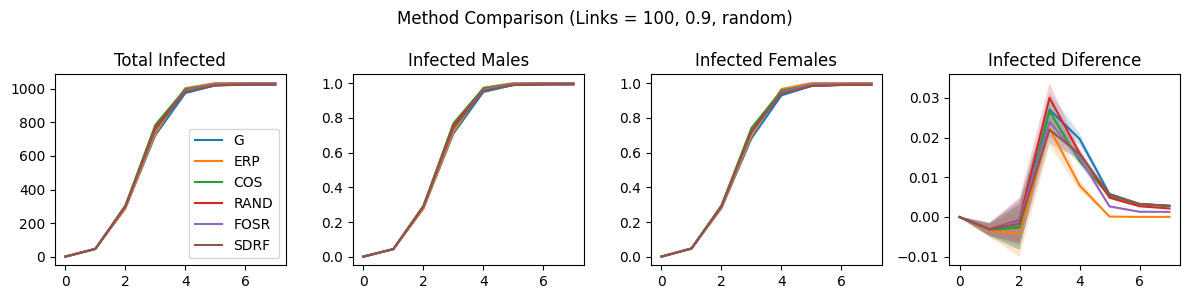

In [652]:
plot_method_comparison(results_dict, ITER_PLOT, attribute_counts, male, female, RUNS)

In [496]:
#wrap_plot_infection_evolution(results_dict['G'], ITER_PLOT)
#wrap_plot_infection_evolution(results_dict['ERP'], ITER_PLOT)

In [373]:
STOP

NameError: name 'STOP' is not defined

## Total Infected people per iteration

In [ ]:
import numpy as np

iterations_G = []
iterations_G_erp = []
iterations_G_cos = []
iterations_G_rand = []

for _ in tqdm(range(80)):
    th = .2
    _, iter_G=IC_model(G, initial_inf_nodes=[min_degree_node], threshold=th, iterations_IC=25)
    _, iter_G_erp=IC_model(G_erp,  initial_inf_nodes=[min_degree_node], threshold=th, iterations_IC=25)
    _, iter_G_cos=IC_model(G_cos,  initial_inf_nodes=[min_degree_node], threshold=th, iterations_IC=25)
    _, iter_G_rand=IC_model(G_rand, initial_inf_nodes=[min_degree_node], threshold=th, iterations_IC=25)

    iterations_G.append([iteration['node_count'][1]+iteration['node_count'][2] for iteration in iter_G])
    iterations_G_erp.append([iteration['node_count'][1]+iteration['node_count'][2] for iteration in iter_G_erp])
    iterations_G_cos.append([iteration['node_count'][1]+iteration['node_count'][2] for iteration in iter_G_cos])
    iterations_G_rand.append([iteration['node_count'][1]+iteration['node_count'][2] for iteration in iter_G_rand])

iterations_G = np.array(iterations_G)
iterations_G_erp = np.array(iterations_G_erp)
iterations_G_cos = np.array(iterations_G_cos)
iterations_G_rand = np.array(iterations_G_rand)

In [43]:
IC_ITER = 25

In [ ]:
fig, ax = plt.subplots(1, figsize=(5, 3))
#show mean and std of each trend
mean_G = iterations_G.mean(axis=0)[:IC_ITER]
std_G = iterations_G.std(axis=0)[:IC_ITER]
ax.plot(mean_G, label='Original')
ax.fill_between(range(IC_ITER), mean_G-std_G, mean_G+std_G, alpha=0.1)

mean_G_erp = iterations_G_erp.mean(axis=0)[:IC_ITER]
std_G_erp = iterations_G_erp.std(axis=0)[:IC_ITER]
ax.plot(mean_G_erp, label='ERP')
ax.fill_between(range(IC_ITER), mean_G_erp-std_G_erp, mean_G_erp+std_G_erp, alpha=0.1)

mean_G_cos = iterations_G_cos.mean(axis=0)[:IC_ITER]
std_G_cos = iterations_G_cos.std(axis=0)[:IC_ITER]
ax.plot(mean_G_cos, label='Cosine')
ax.fill_between(range(IC_ITER), mean_G_cos-std_G_cos, mean_G_cos+std_G_cos, alpha=0.1)

mean_G_rand = iterations_G_rand.mean(axis=0)[:IC_ITER]
std_G_rand = iterations_G_rand.std(axis=0)[:IC_ITER]
ax.plot(mean_G_rand, label='Random')
ax.fill_between(range(IC_ITER), mean_G_rand-std_G_rand, mean_G_rand+std_G_rand, alpha=0.1)

ax.axhline(GW.num_nodes, color='black', linestyle='--')
#ax.set_yscale('log')
ax.set_title('IC')

ax.set_xlabel('Iterations')
ax.set_ylabel('# infected nodes')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
STOP

In [45]:
THRESHOLD_CONFS = [0.2, 0.5, 0.9]
ADDED_LINKS_CONF = [100, 1000]

In [ ]:
exp_results = dict()
for threshold in THRESHOLD_CONFS:
    for added_links in ADDED_LINKS_CONF:
        iterations = dict()
        wrappers = load_augmented_graph_IC(DATASET, added_links)
        for g_name in wrappers:
                iterations[g_name] = []

        for _ in tqdm(range(80), desc=f'Threshold: {threshold}, Links: {added_links}'):
            for g_name in wrappers:
                G = to_nx(wrappers[g_name])
                _, iter_G=IC_model(G, initial_inf_nodes=[min_degree_node], threshold=threshold, iterations_IC=16)
                iterations[g_name].append([iteration['node_count'][1]+iteration['node_count'][2] for iteration in iter_G])

        for g_name in wrappers:
            iterations[g_name] = np.array(iterations[g_name])
        
        exp_results[(threshold, added_links)] = iterations

In [ ]:
string_thresholds = '-'.join([str(th) for th in THRESHOLD_CONFS])
string_links = '-'.join([str(th) for th in ADDED_LINKS_CONF])
string_thresholds

In [54]:
#with open(f'temp_data/IC_RESULTS_{DATASET}_THRESHOLDS_{string_thresholds}_LINKS_{string_links}.pkl', 'wb') as f:
#    pickle.dump(exp_results, f)

In [ ]:
exp_results.keys()

In [ ]:
f, axs = plt.subplots(len(ADDED_LINKS_CONF), len(THRESHOLD_CONFS),figsize=(12, 5))

iters_lim = {0.2:10, 0.5:10, 0.9:10}

for j, threshold in enumerate(THRESHOLD_CONFS):
    for i, added_links in enumerate(ADDED_LINKS_CONF):
        for g_name in exp_results[(threshold, added_links)]:
            mean_G = exp_results[(threshold, added_links)][g_name].mean(axis=0)[:iters_lim[threshold]+1]
            std_G = exp_results[(threshold, added_links)][g_name].std(axis=0)[:iters_lim[threshold]+1]
            if g_name =='ERP':
                label_name = 'ERG'
                color = 'darkgreen'
                lw = 2
            else:
                label_name = g_name
                color = None
                lw = 1
            axs[i,j].plot(mean_G, label=label_name, color=color, lw=lw)
            axs[i,j].fill_between(range(iters_lim[threshold]+1), mean_G-std_G, mean_G+std_G, alpha=0.05)
        axs[i,j].axhline(GW.num_nodes, color='black', linestyle='--')
        axs[i,j].set_title(f'Threshold: {threshold}, Added links: {added_links}')
        axs[i,j].set_xlabel('Iterations')
        axs[i,j].set_ylabel('# infected nodes')
        if i==0 and j==0:
            axs[i,j].legend()
plt.tight_layout()
plt.show()

In [ ]:
STOP

**SIR**

In [ ]:
import numpy as np

BETA = 0.8

iterations_G = []
iterations_G_erp = []
iterations_G_cos = []
iterations_G_rand = []

for _ in tqdm(range(40)):
    iter_G=SIR(G, beta=BETA)
    iter_G_erp=SIR(G_erp, beta=BETA)
    iter_G_cos=SIR(G_cos, beta=BETA)
    iter_G_rand=SIR(G_rand, beta=BETA)

    iterations_G.append([iteration['node_count'][1] for iteration in iter_G])
    iterations_G_erp.append([iteration['node_count'][1] for iteration in iter_G_erp])
    iterations_G_cos.append([iteration['node_count'][1] for iteration in iter_G_cos])
    iterations_G_rand.append([iteration['node_count'][1] for iteration in iter_G_rand])

iterations_G = np.array(iterations_G)
iterations_G_erp = np.array(iterations_G_erp)
iterations_G_cos = np.array(iterations_G_cos)
iterations_G_rand = np.array(iterations_G_rand)

In [ ]:
len(iterations_G)

In [ ]:
SIR_ITER = 5


fig, ax = plt.subplots(1, figsize=(5, 3))
#show mean and std of each trend
mean_G = iterations_G.mean(axis=0)[:SIR_ITER]
std_G = iterations_G.std(axis=0)[:SIR_ITER]
ax.plot(mean_G, label='Original')
ax.fill_between(range(SIR_ITER), mean_G-std_G, mean_G+std_G, alpha=0.2)

mean_G_erp = iterations_G_erp.mean(axis=0)[:SIR_ITER]
std_G_erp = iterations_G_erp.std(axis=0)[:SIR_ITER]
ax.plot(mean_G_erp, label='ERP')
ax.fill_between(range(SIR_ITER), mean_G_erp-std_G_erp, mean_G_erp+std_G_erp, alpha=0.2)

mean_G_cos = iterations_G_cos.mean(axis=0)[:SIR_ITER]
std_G_cos = iterations_G_cos.std(axis=0)[:SIR_ITER]
ax.plot(mean_G_cos, label='Cosine')
ax.fill_between(range(SIR_ITER), mean_G_cos-std_G_cos, mean_G_cos+std_G_cos, alpha=0.2)

mean_G_rand = iterations_G_rand.mean(axis=0)[:SIR_ITER]
std_G_rand = iterations_G_rand.std(axis=0)[:SIR_ITER]
ax.plot(mean_G_rand, label='Random')
ax.fill_between(range(SIR_ITER), mean_G_rand-std_G_rand, mean_G_rand+std_G_rand, alpha=0.2)


#ax.set_yscale('log')
ax.set_title('SIR')

ax.set_xlabel('Iterations')
ax.set_ylabel('# infected nodes')
ax.legend()
plt.tight_layout()
plt.show()

# Visualize random geometric graph

In [ ]:
STOP

In [42]:
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [43]:
# Network topology
g = nx.random_geometric_graph(500, 0.1, seed=896803) # Random Clustered graph 1000 nodes - distance =0.05, no self loops

pos = nx.get_node_attributes(g, "pos")

In [44]:
# get the central node (central regarding the distance to 0.5, 0.5)
dmin = 1
ncenter = 0
for n in pos:
    x, y = pos[n]
    d = (x - 0.5) ** 2 + (y - 0.5) ** 2
    if d < dmin:
        ncenter = n
        dmin = d

# color by path length from node near center
p = dict(nx.single_source_shortest_path_length(g, ncenter))

In [ ]:
plt.figure(figsize=(6, 6))
nx.draw_networkx_edges(g, pos, alpha=0.2, edge_color="grey")
nx.draw_networkx_nodes(
    g,
    pos,
    nodelist=list(p.keys()),
    node_size=40,
    node_color=list(p.values()),
    cmap=plt.cm.Reds_r,
    alpha=0.8
)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.show()